## Philip Morris store sales prediction

<a id='introduction'></a>
## Introduction

The goal of this exercise is to determine which surrounding lead to higher store sales. The data is contained in 2 files:  

1. ‘sales_granular.csv’ - contains information about the sales volumes of a product at particular POS; each POS is uniquely identified by 'store_code'.  
2. ‘Surroundings.json’ - contains information about 90 different amenities (restaurants, shops, beauty salons etc.) that are in the surroundings of each POS.  

This notebook describes the process used to build a regression model to predict store sales based on surroundings.The notebook is divided into the following sections:  

### [Part 1](#part 1)  
Loading and visualzing the data  

### [Part 2](#part 2) 
Feature extraction 

### [Part 3](#part 3)  
Model building 


In [1]:
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from functools import reduce
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import KFold
import scipy.stats as stats
from sklearn.preprocessing import normalize
import re

%matplotlib inline
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (13, 6)
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 999

/Users/abhisek/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/abhisek/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


** Define functions needed to for dataframe manipulation **

In [3]:
# Function to calculate avg hours businesses are open near a store
from collections import defaultdict
import math
def open_hours(periods):
    """Return average hours surrounding businesses are open for any store"""
    
    hours_count = defaultdict(int)
    day_list = ['Monday_hours', 'Tuesday_hours', 'Wednesday_hours', 
                                  'Thursday_hours', 'Friday_hours', 'Saturday_hours', 'Sunday_hours']
    day_dict = {0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday' }
    #print (type(periods))
    if isinstance(periods, list):
        for day in periods:
            try:
                day_of_week = day['close']['day']
                close_time_hours = int(day['close']['time'][0:2])
                close_time_minutes = int(day['close']['time'][-2:])
                open_time_hours = int(day['open']['time'][0:2])
                open_time_minutes = int(day['open']['time'][-2:])
                hours_count[day_dict[day_of_week]+'_hours'] += close_time_hours - open_time_hours + (close_time_minutes - open_time_minutes)/60
            except KeyError:
                continue
    
            
            #print (open_time_hours)
            
            #print (hours_count)

            missing_days_list = [i for i in day_list if i not in hours_count]
            if missing_days_list:
                for x in missing_days_list:
                    hours_count[x] = 0
    
    else:
         hours_count = {'Monday_hours': float('NaN'), 'Tuesday_hours': float('NaN'), 'Wednesday_hours':float('NaN'),
                       'Thursday_hours': float('NaN'), 'Friday_hours': float('NaN'), 'Friday_hours': float('NaN'), 
                       'Saturday_hours': float('NaN'), 'Sunday_hours': float('NaN')}
   
        
        #hours_count[(x for x in day_list and x not in hours_count.keys())] = 0
    return(hours_count)


<a id='part1'></a>  
## Part 1

Loading and Visualizing data

** Load surroundings data **

In [4]:
store_surr = json.load(open('Surroundings.json'))

** Let's look at the type of data present for each surrounding **

In [5]:
def elements_existence(tmp):
    tmp2 = {}
    for x in tmp:
        for a_key in x['surroundings']:
            if a_key not in tmp2:
                tmp2[a_key] = set([])
            this_surr = x['surroundings'][a_key]
            if len(this_surr) < 1:
                next
            for a_place in this_surr:
                tmp2[a_key] = tmp2[a_key].union(set(list(a_place.keys())))
    
    tmp3 = []
    for a_key in tmp2:
        for one_el in tmp2[a_key]:
            tmp3.append((a_key, one_el))

    return pd.DataFrame.\
        from_records(tmp3, columns=['kind', 'element']).\
        assign(value=True).\
        pivot('element', 'kind', 'value').\
        fillna(False).T

In [6]:
elements_existence(store_surr).head()

element,address_components,formatted_address,icon,international_phone_number,latitude,longitude,name,opening_hours,place_id,price_level,rating,reviews,types,user_ratings_total,website
kind,,,,,,,,,,,,,,,
accounting,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True
airport,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True
amusement_park,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True
aquarium,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True
art_gallery,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True


** Counts of attributes for each kind of surrounding **

In [7]:
def elements_count(store_surr):
    ans = elements_existence(store_surr)
    ans.loc[:, :] = 0
    for x in store_surr:
        for surr_kind in x['surroundings']:
            for a_place in x['surroundings'][surr_kind]:
                for attr_type in a_place:
                    ans.loc[surr_kind, attr_type] += 1
    return ans

In [8]:
surr_attr_count = elements_count(store_surr)
surr_attr_count.head()

element,address_components,formatted_address,icon,international_phone_number,latitude,longitude,name,opening_hours,place_id,price_level,rating,reviews,types,user_ratings_total,website
kind,,,,,,,,,,,,,,,
accounting,452.0,452.0,452.0,448.0,452.0,452.0,452.0,276.0,452.0,0.0,90.0,90.0,452.0,89.0,416.0
airport,4.0,4.0,4.0,2.0,4.0,4.0,4.0,1.0,4.0,0.0,1.0,1.0,4.0,1.0,2.0
amusement_park,4.0,4.0,4.0,2.0,4.0,4.0,4.0,1.0,4.0,0.0,3.0,3.0,4.0,3.0,2.0
aquarium,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
art_gallery,393.0,393.0,393.0,358.0,393.0,393.0,393.0,228.0,393.0,0.0,167.0,168.0,393.0,168.0,340.0


In [13]:
# Above table, but in percentages instead of count
surr_attr_count.apply(axis=1, func=lambda x: (x*100/x.max()).round())

element,address_components,formatted_address,icon,international_phone_number,latitude,longitude,name,opening_hours,place_id,price_level,rating,reviews,types,user_ratings_total,website
kind,,,,,,,,,,,,,,,
accounting,100.0,100.0,100.0,99.0,100.0,100.0,100.0,61.0,100.0,0.0,20.0,20.0,100.0,20.0,92.0
airport,100.0,100.0,100.0,50.0,100.0,100.0,100.0,25.0,100.0,0.0,25.0,25.0,100.0,25.0,50.0
amusement_park,100.0,100.0,100.0,50.0,100.0,100.0,100.0,25.0,100.0,0.0,75.0,75.0,100.0,75.0,50.0
aquarium,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,100.0,100.0,100.0,100.0
art_gallery,100.0,100.0,100.0,91.0,100.0,100.0,100.0,58.0,100.0,0.0,42.0,43.0,100.0,43.0,87.0
atm,100.0,100.0,100.0,82.0,100.0,100.0,100.0,53.0,100.0,0.0,31.0,31.0,100.0,31.0,87.0
bakery,100.0,100.0,100.0,96.0,100.0,100.0,100.0,79.0,100.0,0.0,74.0,75.0,100.0,75.0,82.0
bank,100.0,100.0,100.0,87.0,100.0,100.0,100.0,71.0,100.0,0.0,49.0,49.0,100.0,49.0,84.0
bar,100.0,100.0,100.0,89.0,100.0,100.0,100.0,79.0,100.0,0.0,89.0,89.0,100.0,89.0,79.0


** What type of surroundings are most frequent **

In [14]:
surr_attr_count.apply(axis=1, func=lambda x: x.max()).sort_values(ascending=False)

kind
store                      14305.0
restaurant                  6812.0
doctor                      6500.0
clothing_store              4663.0
real_estate_agency          3856.0
hair_care                   3665.0
dentist                     2466.0
beauty_salon                2324.0
lawyer                      1927.0
home_goods_store            1890.0
bar                         1800.0
transit_station             1760.0
bank                        1729.0
cafe                        1502.0
bus_station                 1468.0
travel_agency               1461.0
lodging                     1353.0
physiotherapist             1351.0
jewelry_store               1296.0
electronics_store           1265.0
shoe_store                  1253.0
atm                         1133.0
bakery                       958.0
insurance_agency             916.0
pharmacy                     875.0
gym                          855.0
meal_takeaway                789.0
furniture_store              711.0
spa            

** What type of attribute information is frequently present about a surrounding **

In [15]:
surr_attr_count.apply(axis=0, func=lambda x: x.sum()).sort_values(ascending=False).head()

element
types        82085.0
place_id     82085.0
name         82085.0
longitude    82085.0
latitude     82085.0
dtype: float64

** Count by store and surroundings kind **

In [16]:
def _count_by_kind(x):
    all_kinds = list(x.keys())
    kind_nums = [len(x[y]) for y in all_kinds]
    return pd.DataFrame({'kind': all_kinds, 'num': kind_nums})

def count_by_kind(x):
    return pd.concat([_count_by_kind(y['surroundings']).assign(store_code = y['store_code']) for y in x])

In [17]:
count_by_kind(store_surr).head()

,kind,num,store_code
0,subway_station,0,10055
1,department_store,0,10055
2,embassy,0,10055
3,beauty_salon,4,10055
4,police,0,10055


### Flatten the data & store in a dataframe

In [18]:
def flatten_data(store_surr):
    data_flat = []
    for x in store_surr:
        this_store = x['store_code']
        for surr_kind in x['surroundings']:
            this_kind = surr_kind
            for a_place in x['surroundings'][surr_kind]:
                this_place_id = a_place['place_id']
                this_lat = a_place['latitude']
                this_lon = a_place['longitude']
                this_types = a_place['types']
                this_oh = None if 'opening_hours' not in a_place else a_place['opening_hours']
                this_reviews = None if 'reviews' not in a_place else a_place['reviews']
                this_ur = None if 'user_ratings_total' not in a_place else a_place['user_ratings_total']
                this_rating = None if 'rating' not in a_place else a_place['rating']
                this_pl = None if 'price_level' not in a_place else a_place['price_level']
                data_flat.append((
                    this_store,
                    this_kind,
                    this_place_id,
                    this_lat,
                    this_lon,
                    this_types,
                    this_oh,
                    this_reviews,
                    this_ur,
                    this_rating,
                    this_pl
                ))
    return pd.DataFrame.from_records(data_flat,
                              columns=[
                                  'store_code',
                                  'surr_kind',
                                  'place_id',
                                  'latitude',
                                  'longitude',
                                  'types',
                                  'opening_hours',
                                  'reviews',
                                  'user_ratings_total',
                                  'rating',
                                  'price_level'
                              ])

In [19]:
data_flat = flatten_data(store_surr)

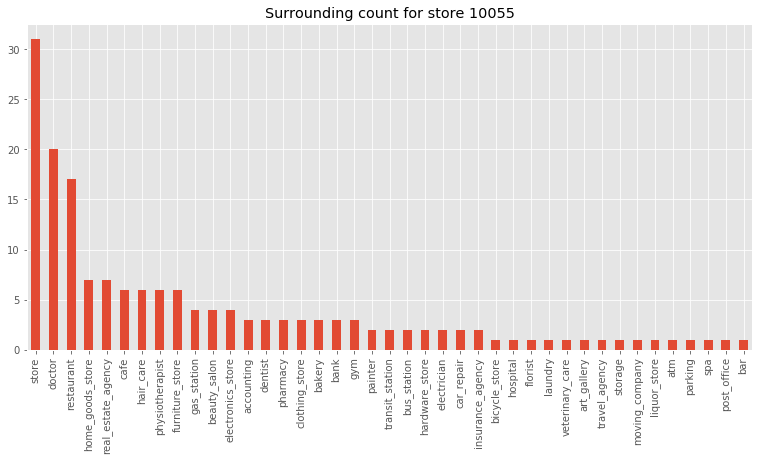

In [20]:
# Let's examine one store
one_store = data_flat[data_flat['store_code'] == 10055]
one_store.head()
pd.value_counts(one_store['surr_kind']).plot.bar()
plt.title('Surrounding count for store 10055');

<a id='part2'></a>  
## Part 2  

Feature extraction

In [21]:
print(len(data_flat.surr_kind.unique()))
data_flat['surr_kind'].value_counts()

87


store                      14305
restaurant                  6812
doctor                      6500
clothing_store              4663
real_estate_agency          3856
hair_care                   3665
dentist                     2466
beauty_salon                2324
lawyer                      1927
home_goods_store            1890
bar                         1800
transit_station             1760
bank                        1729
cafe                        1502
bus_station                 1468
travel_agency               1461
lodging                     1353
physiotherapist             1351
jewelry_store               1296
electronics_store           1265
shoe_store                  1253
atm                         1133
bakery                       958
insurance_agency             916
pharmacy                     875
gym                          855
meal_takeaway                789
furniture_store              711
spa                          574
florist                      567
local_gove

In [22]:
# There are many surrounding types that have lesser counts 
# All the types with less than 500 count will be merged into one single category
data_flat['surr_kind_count'] = data_flat.groupby('surr_kind')['store_code'].transform('count')
data_flat.loc[data_flat.surr_kind_count < 500, 'surr_kind'] = 'miscellaneous'

In [23]:
data_flat.drop(['surr_kind_count'], axis=1,inplace=True)
data_flat.sample(5)

,store_code,surr_kind,place_id,latitude,longitude,types,opening_hours,reviews,user_ratings_total,rating,price_level
61409,29015,miscellaneous,ChIJg-YeH5_7j0cR05MJamrVBno,47.049676,8.307302,"[museum, point_of_interest, establishment]",None,"[{'rating': 5, 'author_name': 'Daniel Arnold',...",1.0,5.0,NaN
10372,13798,pharmacy,ChIJ17ID4UV7jEcRC68svv20Q6c,46.188818,6.110856,"[pharmacy, health, store, point_of_interest, e...","{'weekday_text': ['Monday: 8:30 AM – 7:00 PM',...","[{'rating': 2, 'author_name': 'Rateb Dabour', ...",2.0,3.0,NaN
42170,25270,atm,ChIJbVUdyHDHhEcRaVWvJfRd2tE,46.850597,9.532235,"[bank, atm, finance, point_of_interest, establ...","{'weekday_text': ['Monday: 9:00 AM – 5:00 PM',...","[{'rating': 5, 'author_name': 'Alessia Riva', ...",1.0,5.0,NaN
4173,11007,real_estate_agency,ChIJgWKsoy1pjkcRUwFt4sd5NbU,46.803964,7.156036,"[real_estate_agency, point_of_interest, establ...","{'weekday_text': ['Monday: 9:00 AM – 12:00 PM,...","[{'rating': 1, 'author_name': 'Sunny Sun', 'la...",4.0,2.0,NaN
68913,30518,real_estate_agency,ChIJ4entlcC3kUcRjf-SkOTRDiI,47.527618,7.648054,"[real_estate_agency, finance, point_of_interes...","{'weekday_text': ['Monday: 8:00 AM – 12:00 PM,...",None,NaN,NaN,NaN


Let's create new features with user_total_ratings, rating and price_level. This will give us an indication as to whether the surroundings have highly rates places nearby and how expensive establishments are near each store.

In [24]:
feat_df_1 = data_flat.groupby(['store_code', 'surr_kind'])['place_id'].count().reset_index()\
    .pivot('store_code', 'surr_kind', 'place_id')\
    .fillna(0)\
    .reset_index()
feat_df_1.sample(5)

surr_kind,store_code,atm,bakery,bank,bar,beauty_salon,book_store,bus_station,cafe,clothing_store,dentist,doctor,electronics_store,florist,furniture_store,gym,hair_care,home_goods_store,insurance_agency,jewelry_store,lawyer,local_government_office,lodging,meal_takeaway,miscellaneous,pharmacy,physiotherapist,real_estate_agency,restaurant,shoe_store,spa,store,transit_station,travel_agency
523,36589,0.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,2.0,4.0,0.0,1.0,10.0,2.0,0.0
263,24958,2.0,2.0,1.0,5.0,4.0,0.0,1.0,5.0,4.0,3.0,8.0,3.0,0.0,1.0,1.0,5.0,2.0,2.0,0.0,1.0,1.0,2.0,1.0,23.0,1.0,0.0,2.0,10.0,0.0,1.0,21.0,2.0,0.0
496,32411,5.0,1.0,5.0,3.0,2.0,3.0,2.0,5.0,4.0,12.0,20.0,5.0,1.0,0.0,6.0,5.0,2.0,1.0,0.0,5.0,2.0,1.0,2.0,23.0,1.0,2.0,5.0,11.0,0.0,0.0,36.0,2.0,2.0
218,22550,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,2.0,0.0,0.0,6.0,1.0,0.0
445,30877,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0


In [25]:
feat_df_2 = data_flat.groupby('store_code')['user_ratings_total'].sum().reset_index()
feat_df_2.sample(5)

,store_code,user_ratings_total
164,20902,76.0
471,31866,208.0
348,27794,21.0
444,30864,665.0
324,27198,3233.0


In [26]:
feat_df_3 = data_flat.\
    loc[lambda x: ~x.user_ratings_total.isnull(), :]\
    .groupby('store_code')['user_ratings_total'].count().reset_index()\
    .rename(columns={'user_ratings_total': 'num_places_rating_non_na'})
feat_df_3.sample(5)

,store_code,num_places_rating_non_na
339,27492,54
492,32305,65
342,27618,57
252,24438,13
153,20429,29


In [27]:
feat_df_4 = data_flat.groupby('store_code')['rating'].mean().reset_index()
feat_df_4.sample(5)

,store_code,rating
221,22743,4.266667
295,26307,4.607143
61,12978,4.625000
384,29278,4.177143
289,25869,4.229032


In [28]:
feat_df_5 = data_flat.groupby('store_code')['price_level'].mean().reset_index()
feat_df_5.sample(5)

,store_code,price_level
112,17965,2.00
427,30472,NaN
248,24363,1.00
386,29298,NaN
211,22279,1.75


We will also create a new feature called 'total_surrs' to indicate the total number of surroundings near each store.

In [29]:
feat_df_6 = data_flat.groupby(['store_code'])['place_id'].count().reset_index()\
    .rename(columns={'place_id': 'tot_surrs'})
feat_df_6.sample(5)

,store_code,tot_surrs
441,30819,84
512,32952,164
328,27258,70
266,25072,144
250,24375,83


In [33]:
data_flat1 = pd.concat([data_flat.drop(['opening_hours'], axis=1), data_flat['opening_hours'].apply(pd.Series)], axis=1)
data_flat1['day_open_hours'] = data_flat1.apply(lambda row: open_hours(row['periods']), axis=1)
data_flat1 = pd.concat([data_flat1.drop(['day_open_hours'], axis=1), data_flat1['day_open_hours'].apply(pd.Series)], axis=1)

In [34]:
data_flat1.head(5)

,store_code,surr_kind,place_id,latitude,longitude,types,reviews,user_ratings_total,rating,price_level,open_now,periods,weekday_text,Friday_hours,Monday_hours,Saturday_hours,Sunday_hours,Thursday_hours,Tuesday_hours,Wednesday_hours
0,10055,beauty_salon,ChIJQX0xf_1vjEcRb3nniibfdv0,46.195210,6.192416,"[beauty_salon, point_of_interest, establishment]","[{'rating': 4, 'author_name': 'Eladia Ballmann...",1.0,4.0,NaN,True,"[{'close': {'day': 1, 'time': '1800'}, 'open':...","[Monday: 9:00 AM – 6:00 PM, Tuesday: 9:00 AM –...",9.0,9.0,9.0,0.0,9.0,9.0,9.0
1,10055,beauty_salon,ChIJpfgrh_1vjEcRg0Pib7g1uIE,46.195151,6.191925,"[hair_care, beauty_salon, point_of_interest, e...",None,NaN,NaN,NaN,True,"[{'close': {'day': 1, 'time': '1800'}, 'open':...","[Monday: 10:00 AM – 6:00 PM, Tuesday: 10:00 AM...",8.0,8.0,4.0,0.0,8.0,8.0,8.0
2,10055,beauty_salon,ChIJt8BJnQJwjEcRxJuVWPGQsoM,46.194893,6.192968,"[hair_care, beauty_salon, point_of_interest, e...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10055,beauty_salon,ChIJB-CPkAJwjEcRqMJvH_ZnFkI,46.194317,6.193033,"[beauty_salon, point_of_interest, establishment]",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10055,pharmacy,ChIJJ3Kgx-JvjEcRv51dE6X9Ri8,46.195766,6.196418,"[pharmacy, health, clothing_store, store, poin...",None,NaN,NaN,NaN,True,"[{'close': {'day': 1, 'time': '1900'}, 'open':...","[Monday: 8:30 AM – 7:00 PM, Tuesday: 8:30 AM –...",10.5,10.5,10.0,0.0,10.5,10.5,10.5


Let's create a set of new features which show the average number of hours businesses are open surrounding a store. this feature may or may not be used in modeling.

In [35]:
feat_df_7 = data_flat1.groupby('store_code')['Friday_hours', 'Monday_hours', 'Saturday_hours', 'Sunday_hours', 
                                            'Thursday_hours', 'Tuesday_hours', 'Wednesday_hours'].mean().reset_index()
feat_df_7.head()

,store_code,Friday_hours,Monday_hours,Saturday_hours,Sunday_hours,Thursday_hours,Tuesday_hours,Wednesday_hours
0,282,7.240228,6.563518,3.977742,-0.225027,8.418567,8.219055,8.121336
1,425,7.115385,6.480769,4.961538,-0.384615,7.692308,7.692308,9.057692
2,1498,7.330189,6.317610,3.366352,0.168239,7.797170,7.919811,7.872642
3,2286,7.596702,7.276738,4.634135,0.917112,7.662210,7.781194,7.773173
4,2331,8.912460,7.798544,6.189320,1.123786,8.915049,8.953883,8.618932


In [36]:
feat_df_7 = feat_df_7.fillna(0)

** Combine all feature to create final feature dataframe **

In [37]:
all_feats = reduce(lambda x, y: pd.merge(x, y, on='store_code', how='inner'),
                   [feat_df_2, feat_df_3, feat_df_4, feat_df_5, feat_df_6, feat_df_6], feat_df_1)

In [38]:
# Let'c create a new column is_price_level_null to fill columns that have missing price level
all_feats['is_price_level_null'] = all_feats.price_level.isnull()
all_feats.loc[all_feats.is_price_level_null, 'price_level'] = all_feats.price_level.mean()
all_feats.sample(5)

,store_code,atm,bakery,bank,bar,beauty_salon,book_store,bus_station,cafe,clothing_store,dentist,doctor,electronics_store,florist,furniture_store,gym,hair_care,home_goods_store,insurance_agency,jewelry_store,lawyer,local_government_office,lodging,meal_takeaway,miscellaneous,pharmacy,physiotherapist,real_estate_agency,restaurant,shoe_store,spa,store,transit_station,travel_agency,user_ratings_total,num_places_rating_non_na,rating,price_level,tot_surrs_x,tot_surrs_y,is_price_level_null
189,21630,2.0,1.0,2.0,3.0,5.0,0.0,6.0,1.0,7.0,2.0,12.0,2.0,0.0,0.0,1.0,7.0,3.0,2.0,0.0,0.0,0.0,1.0,0.0,15.0,1.0,6.0,2.0,18.0,0.0,0.0,37.0,7.0,5.0,1193.0,83,4.418072,1.668039,148,148,True
418,30332,0.0,1.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,0.0,1.0,2.0,0.0,0.0,7.0,3.0,1.0,116.0,18,4.550000,1.668039,34,34,True
264,24974,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,1.0,1.0,2.0,0.0,8.0,1.0,0.0,146.0,20,4.330000,1.668039,33,33,True
173,21136,3.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,0.0,1.0,5.0,2.0,2.0,1.0,1.0,2.0,3.0,1.0,1.0,0.0,1.0,2.0,0.0,9.0,1.0,0.0,2.0,1.0,0.0,1.0,15.0,4.0,4.0,290.0,39,4.356410,1.668039,73,73,True
477,32005,1.0,4.0,3.0,1.0,0.0,0.0,2.0,0.0,0.0,2.0,4.0,1.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,0.0,1.0,14.0,2.0,2.0,4.0,6.0,0.0,0.0,22.0,2.0,2.0,215.0,41,4.497436,1.668039,81,81,True


** Read sales data file & aggregate to create target variable **

In [39]:
# Read the store sales file
sales_df = pd.read_csv('sales_granular.csv')
print (sales_df.shape)

(906, 11937)


In [40]:
sales_df.sample(5)

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,8/3/15 18:00,8/3/15 19:00,8/3/15 22:00,8/4/15 8:00,8/4/15 9:00,8/4/15 10:00,8/4/15 11:00,8/4/15 12:00,8/4/15 13:00,8/4/15 14:00,8/4/15 15:00,8/4/15 16:00,8/4/15 17:00,8/4/15 18:00,8/4/15 19:00,8/4/15 20:00,8/5/15 7:00,8/5/15 9:00,8/5/15 10:00,8/5/15 11:00,8/5/15 12:00,8/5/15 13:00,8/5/15 14:00,8/5/15 15:00,8/5/15 16:00,8/5/15 17:00,8/5/15 18:00,8/5/15 19:00,8/5/15 20:00,8/6/15 9:00,8/6/15 10:00,8/6/15 11:00,8/6/15 12:00,8/6/15 13:00,8/6/15 14:00,8/6/15 15:00,8/6/15 16:00,8/6/15 17:00,8/6/15 18:00,8/6/15 19:00,...,6/23/17 11:00,6/23/17 12:00,6/23/17 13:00,6/23/17 14:00,6/23/17 15:00,6/23/17 16:00,6/23/17 17:00,6/23/17 18:00,6/23/17 19:00,6/23/17 20:00,6/23/17 21:00,6/23/17 22:00,6/23/17 23:00,6/24/17 0:00,6/24/17 5:00,6/24/17 6:00,6/24/17 7:00,6/24/17 8:00,6/24/17 9:00,6/24/17 10:00,6/24/17 11:00,6/24/17 12:00,6/24/17 13:00,6/24/17 14:00,6/24/17 15:00,6/24/17 16:00,6/24/17 17:00,6/24/17 18:00,6/24/17 19:00,6/24/17 20:00,6/24/17 21:00,6/24/17 22:00,6/24/17 23:00,6/25/17 6:00,6/25/17 7:00,6/25/17 8:00,6/25/17 9:00,6/25/17 10:00,6/25/17 11:00,6/25/17 12:00,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
469,26816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,13336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,10672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
681,31322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,450.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150.0,600.0,NaN,NaN,NaN,90.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
556,28804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are a large number of NaN's in the sales dataset and the sales values do not seem to reported at fixed intervals. This rules out the possibility of assuming weekly or monthly reporting of sales. For the purpose of this exercise we will assume that the stores were all open at the initial date of opening and that the sales are cyclical over a one-year period. We will sum the sales from  '6/25/16 9:00' and assume that as the target variable.

In [41]:
sales_df0 = pd.concat([sales_df.loc[:, 'store_code'], sales_df.loc[:, '6/25/16 9:00':]], axis=1)
# Sum and divide by number of days to get sales per day
sales_df0['total_rev'] = sales_df0.sum(axis=1)
sales_total_df= sales_df0[['store_code', 'total_rev']]
sales_total_df.head()

,store_code,total_rev
0,10055,41585.0
1,10077,13977.0
2,10079,263099.0
3,10081,391921.0
4,10085,52265.0


In [42]:
#Let's look at some statistics for the total_sales
minimum_sales = min(sales_total_df['total_rev'])

maximum_sales = max(sales_total_df['total_rev'])

mean_sales = np.mean(sales_total_df['total_rev'])

median_sales = np.median(sales_total_df['total_rev'])

std_sales = np.std(sales_total_df['total_rev'])

print ("Statistics for total revenue:\n")
print ("Minimum revenue: ${:,.2f}".format(minimum_sales))
print ("Maximum revenue: ${:,.2f}".format(maximum_sales))
print ("Mean revenue: ${:,.2f}".format(mean_sales))
print ("Median revenue ${:,.2f}".format(median_sales))
print ("Standard deviation of revenue: ${:,.2f}".format(std_sales))

Statistics for total revenue:

Minimum revenue: $1,235.00
Maximum revenue: $2,060,238.00
Mean revenue: $81,961.63
Median revenue $36,793.50
Standard deviation of revenue: $172,396.97


(array([789.,  51.,  24.,  12.,  14.,   3.,   2.,   2.,   1.,   0.,   1.,
          1.,   0.,   1.,   0.,   2.,   1.,   0.,   1.,   1.]),
 array([1.23500000e+03, 1.04185150e+05, 2.07135300e+05, 3.10085450e+05,
        4.13035600e+05, 5.15985750e+05, 6.18935900e+05, 7.21886050e+05,
        8.24836200e+05, 9.27786350e+05, 1.03073650e+06, 1.13368665e+06,
        1.23663680e+06, 1.33958695e+06, 1.44253710e+06, 1.54548725e+06,
        1.64843740e+06, 1.75138755e+06, 1.85433770e+06, 1.95728785e+06,
        2.06023800e+06]),
 <a list of 20 Patch objects>)

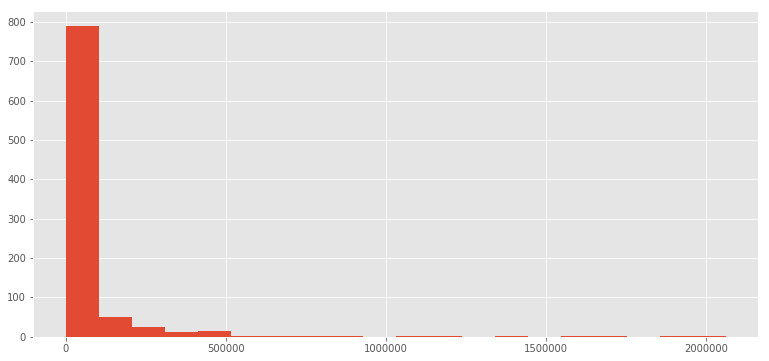

In [43]:
# plot histogram of total_sales
plt.hist(sales_total_df.total_rev, bins=20)

In [44]:
# Based on the above graph let's filter out revenues over 500,000
sales_total_df1 = sales_total_df[sales_total_df['total_rev'] < 500000]

In [45]:
sales_df1 = pd.merge(sales_df, sales_total_df1, how = 'inner', on='store_code')
sales_df1.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,8/3/15 18:00,8/3/15 19:00,8/3/15 22:00,8/4/15 8:00,8/4/15 9:00,8/4/15 10:00,8/4/15 11:00,8/4/15 12:00,8/4/15 13:00,8/4/15 14:00,8/4/15 15:00,8/4/15 16:00,8/4/15 17:00,8/4/15 18:00,8/4/15 19:00,8/4/15 20:00,8/5/15 7:00,8/5/15 9:00,8/5/15 10:00,8/5/15 11:00,8/5/15 12:00,8/5/15 13:00,8/5/15 14:00,8/5/15 15:00,8/5/15 16:00,8/5/15 17:00,8/5/15 18:00,8/5/15 19:00,8/5/15 20:00,8/6/15 9:00,8/6/15 10:00,8/6/15 11:00,8/6/15 12:00,8/6/15 13:00,8/6/15 14:00,8/6/15 15:00,8/6/15 16:00,8/6/15 17:00,8/6/15 18:00,8/6/15 19:00,...,6/23/17 12:00,6/23/17 13:00,6/23/17 14:00,6/23/17 15:00,6/23/17 16:00,6/23/17 17:00,6/23/17 18:00,6/23/17 19:00,6/23/17 20:00,6/23/17 21:00,6/23/17 22:00,6/23/17 23:00,6/24/17 0:00,6/24/17 5:00,6/24/17 6:00,6/24/17 7:00,6/24/17 8:00,6/24/17 9:00,6/24/17 10:00,6/24/17 11:00,6/24/17 12:00,6/24/17 13:00,6/24/17 14:00,6/24/17 15:00,6/24/17 16:00,6/24/17 17:00,6/24/17 18:00,6/24/17 19:00,6/24/17 20:00,6/24/17 21:00,6/24/17 22:00,6/24/17 23:00,6/25/17 6:00,6/25/17 7:00,6/25/17 8:00,6/25/17 9:00,6/25/17 10:00,6/25/17 11:00,6/25/17 12:00,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00,total_rev
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41585.0
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13977.0
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,300.0,30.0,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,360.0,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263099.0
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,120.0,NaN,30.0,NaN,NaN,300.0,NaN,60.0,NaN,90.0,330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,60.0,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN,391921.0
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52265.0


In [63]:
# Merge features and target variable dataframe to create final dataframe for modeling
final_df = pd.merge(sales_total_df,all_feats, how = 'inner', on='store_code' )

In [148]:
final_df = pd.merge(sales_total_df, all_feats, how = 'inner', on='store_code' )
final_df.head()

,store_code,total_rev,atm,bakery,bank,bar,beauty_salon,book_store,bus_station,cafe,clothing_store,dentist,doctor,electronics_store,florist,furniture_store,gym,hair_care,home_goods_store,insurance_agency,jewelry_store,lawyer,local_government_office,lodging,meal_takeaway,miscellaneous,pharmacy,physiotherapist,real_estate_agency,restaurant,shoe_store,spa,store,transit_station,travel_agency,user_ratings_total,num_places_rating_non_na,rating,price_level,tot_surrs_x,tot_surrs_y,is_price_level_null
0,10055,41585.0,1.0,3.0,3.0,1.0,4.0,0.0,2.0,6.0,3.0,3.0,20.0,4.0,1.0,6.0,3.0,6.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,25.0,3.0,6.0,7.0,17.0,0.0,1.0,31.0,2.0,1.0,630.0,79,4.239241,1.668039,168,168,True
1,10077,13977.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,6.0,1.0,0.0,76.0,9,4.266667,1.668039,18,18,True
2,10079,263099.0,3.0,3.0,1.0,4.0,4.0,1.0,4.0,4.0,11.0,12.0,13.0,2.0,1.0,0.0,1.0,9.0,3.0,2.0,4.0,0.0,1.0,0.0,2.0,20.0,3.0,1.0,3.0,15.0,4.0,1.0,53.0,4.0,2.0,1329.0,108,4.065741,1.000000,191,191,False
3,10086,43896.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,2.0,2.0,0.0,0.0,3.0,1.0,0.0,93.0,17,4.070588,1.668039,25,25,True
4,10111,28111.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,4.0,0.0,401.0,11,3.872727,1.668039,23,23,True


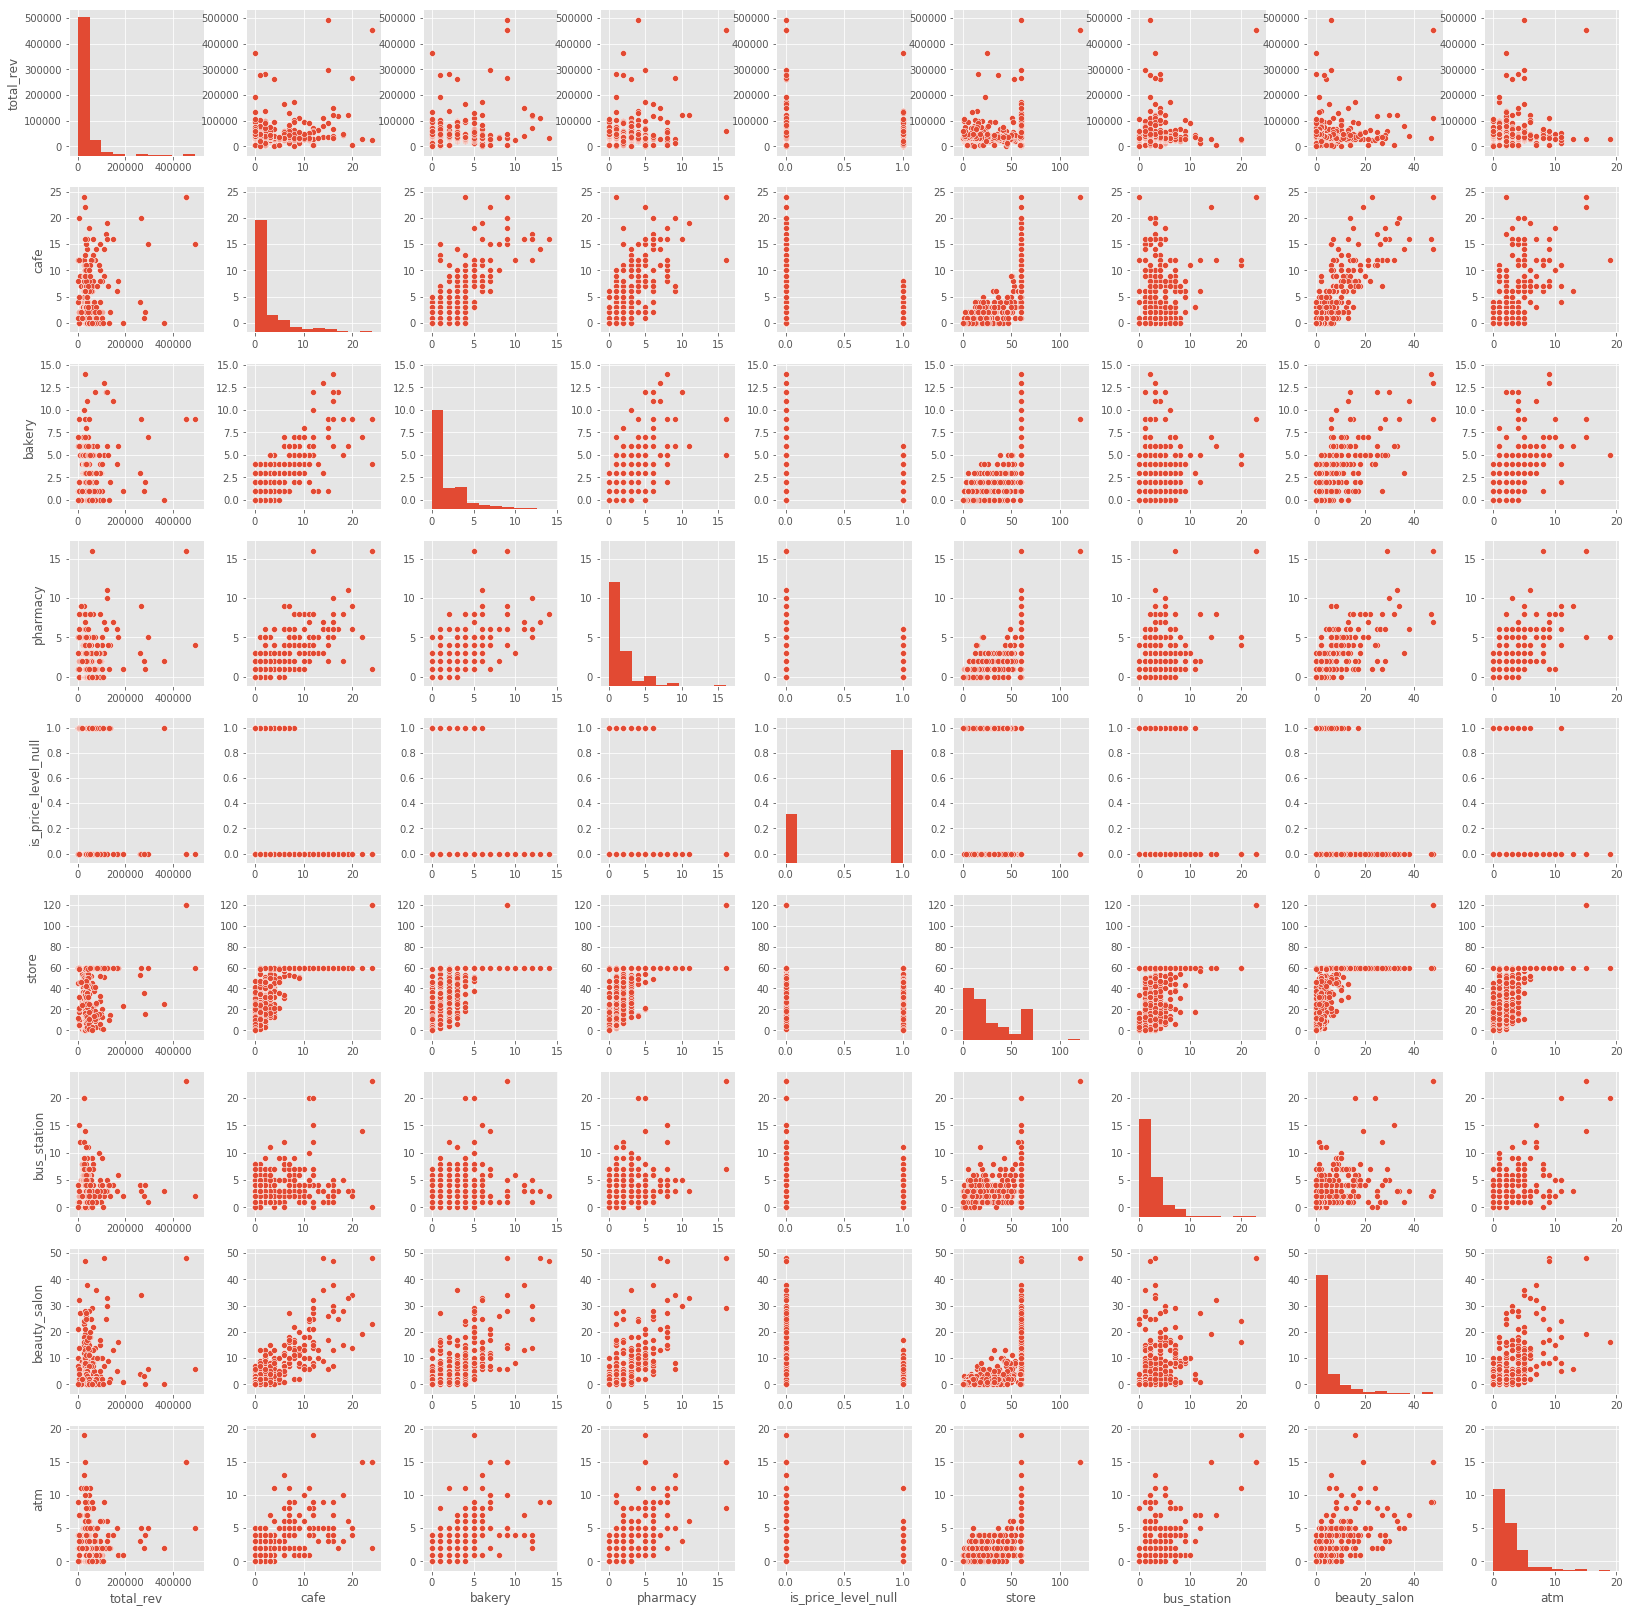

In [150]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(final_df[['total_rev', 'cafe','bakery', 'pharmacy', 'is_price_level_null', 'store',
                      'bus_station', 'beauty_salon', 'atm']])

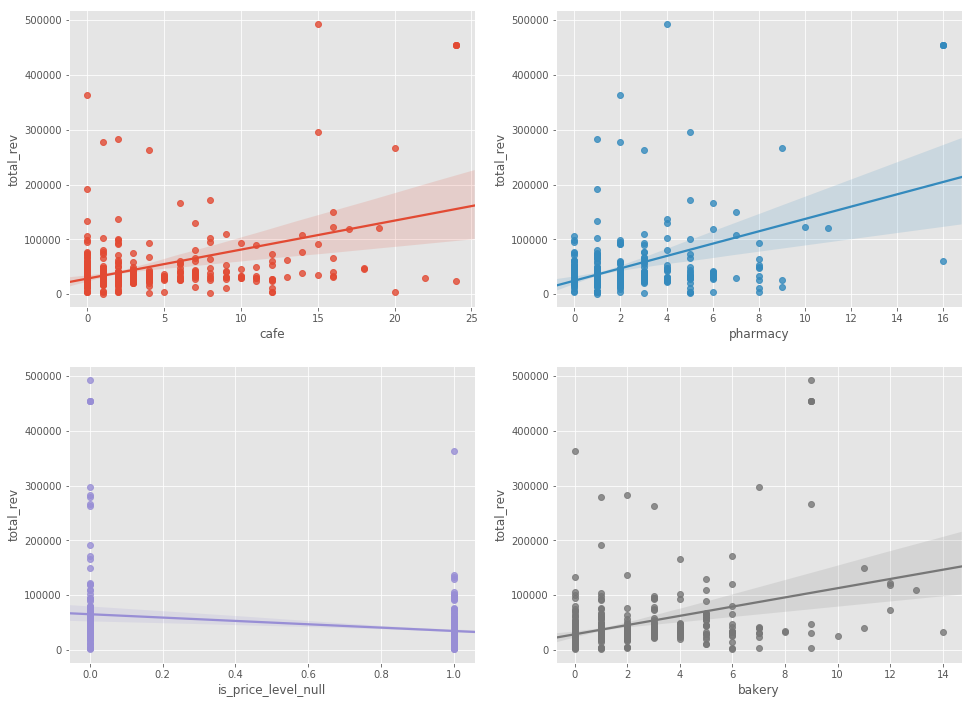

In [145]:
def running_mean(l, N=10):
    sum = 0
    result = list( 0 for x in l)

    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)

    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N

    return result


fig, ax = plt.subplots(2, 2, figsize=(16,12))
sns.regplot(x="cafe", y="total_rev", data=final_df, ax=ax[0][0])
sns.regplot(x="pharmacy", y="total_rev", data=final_df, ax=ax[0][1])
sns.regplot(x="is_price_level_null", y="total_rev", data=final_df, ax=ax[1][0])
sns.regplot(x="bakery", y="total_rev", data=final_df, ax=ax[1][1])

<a id='part3'></a>  
## Part 3  

Model Building

In [91]:
# Create feature matrix (X) and target vector (y)
y = final_df[['total_rev']]
X = final_df.drop(['store_code', 'total_rev'],1)

** Split data into test and train sets **

In [92]:
X.is_price_level_null = X.is_price_level_null.astype('float64')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

** Model 1. Ordinary Least Squares Regression **

In [93]:
model = sm.OLS(y, X)
# Fit your model to training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_rev   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     28.61
Date:                Fri, 20 Apr 2018   Prob (F-statistic):          4.45e-101
Time:                        19:14:52   Log-Likelihood:                -6400.8
No. Observations:                 534   AIC:                         1.288e+04
Df Residuals:                     496   BIC:                         1.304e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
atm                        302.9765   1324.805      0.229      0.819   -2299.946    2905.899
bakery                    4700.6123   1594.291      2.948      0.003    1568.215    7833.010
bank                     -2306.5748    756.063     -3.051      0.002   -3792.056    -821.093
bar                        194.4204    870.597      0.223      0.823   -1516.091    1904.932
beauty_salon             -2024.0793   1046.958     -1.933      0.054   -4081.099      32.940
book_store               -8781.7558   1748.276     -5.023      0.000   -1.22e+04   -5346.817
bus_station               2200.9410   2534.915      0.868      0.386   -2779.554    7181.437
cafe                      7130.3378   1287.851      5.537      0.000    4600.022    9660.653
clothing_store             525.8034    518.720      1.014      0.311    -493.356    1544.963
dentist                    144.6288    752.153      0.192      0.848   -1333.169    1622.427
doctor                    -329.9407    360.339     -0.916      0.360   -1037.920     378.039
electronics_store        -4145.2509    942.045     -4.400      0.000   -5996.142   -2294.360
florist                  -6495.2407   1971.625     -3.294      0.001   -1.04e+04   -2621.474
furniture_store          -4094.8929   2093.108     -1.956      0.051   -8207.345      17.559
gym                       2510.1672   1231.290      2.039      0.042      90.979    4929.355
hair_care                 1229.2778    772.398      1.592      0.112    -288.297    2746.853
home_goods_store          1409.3535   1378.974      1.022      0.307   -1299.998    4118.705
insurance_agency         -1737.6906   1142.587     -1.521      0.129   -3982.599     507.218
jewelry_store              931.5818    879.693      1.059      0.290    -796.802    2659.966
lawyer                     867.1969    707.743      1.225      0.221    -523.347    2257.741
local_government_office    273.5014    847.843      0.323      0.747   -1392.306    1939.308
lodging                   -341.8255    582.214     -0.587      0.557   -1485.736     802.085
meal_takeaway              487.9199   1751.572      0.279      0.781   -2953.496    3929.335
miscellaneous              325.1475    382.283      0.851      0.395    -425.945    1076.240
pharmacy                  5576.8802   1680.655      3.318      0.001    2274.800    8878.961
physiotherapist            657.2467   1042.464      0.630      0.529   -1390.944    2705.437
real_estate_agency        -107.3332    485.460     -0.221      0.825   -1061.144     846.478
restaurant               -1420.4956    527.437     -2.693      0.007   -2456.781    -384.210
shoe_store                -767.6268   1184.778     -0.648      0.517   -3095.430    1560.176
spa                        892.2944   1790.293      0.498      0.618   -2625.199    4409.788
store         

In [94]:
### Let's look at the residuals & Q-Q plot

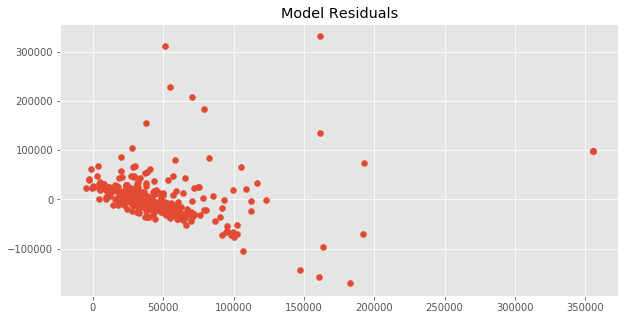

In [95]:
y_pred = fit.predict(X)
xs = range(len(y_pred))

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, fit.resid)
plt.title('Model Residuals');

The residuals seem OK, they do not seem to suggest heteroskedasticity.

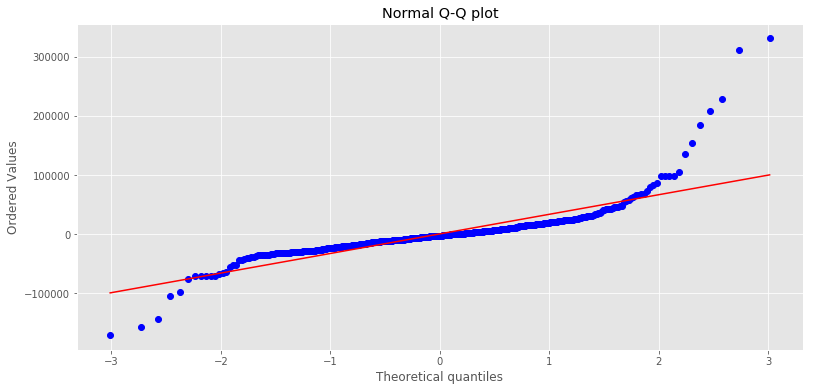

In [96]:
import scipy.stats as stats
stats.probplot(fit.resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

** Model 2. Linear Regression with sklearn **

In [97]:
X_nm=normalize(X,axis=0,norm='max')
y_nm=normalize(y,axis=0,norm='max')
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_nm, y_nm, test_size=0.25)
# Create an empty model
lr = LinearRegression()
# Fit the model to the full dataset
fit = lr.fit(X_train_nm, y_train_nm)
# Print out the R^2 for the model against the full dataset
print ("R_square linear regression: %0.2f" % lr.score(X_test_nm, y_test_nm))

R_square linear regression: 0.41


** Model 3: Lasso regression with cross validation **

In [98]:
col_list_x=X.columns
col_list_y=y.columns
X_cv=pd.DataFrame(X_nm, columns=col_list_x)
y_cv=pd.DataFrame(y_nm, columns=col_list_y)

In [99]:
# Lasso using cross validation
kf = KFold(n=len(X), n_folds=10, shuffle=True)
all_scores=[]
alphas=[1e-5,1e-3,1e-2,1e-1,0.15,0.2]

for train, test in kf:
    X_train1=X_cv.iloc[train]
    y_train1=y_cv.iloc[train]
    X_test1=X_cv.iloc[test]
    y_test1=y_cv.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(X_train1,y_train1)
        p = est.predict(X_test1)
        mse=np.mean((np.array(y_test1)-p)**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

/Users/abhisek/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [100]:
all_scores[2]

[0.014116370723798942,
 0.012271163415392139,
 0.010586638618184057,
 0.01051136903036663,
 0.01051136903036663,
 0.01051136903036663]

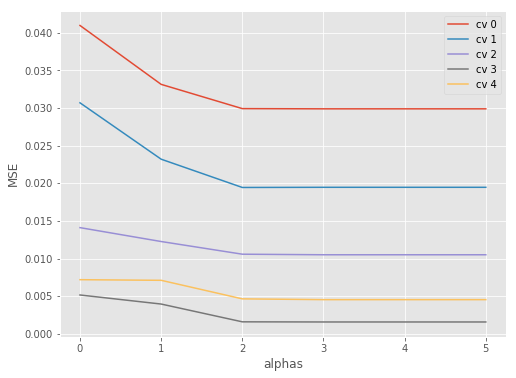

In [101]:
# Which alpha is the best for our model ? Looks like alpha= 1e-3
plt.figure(figsize=(8,6))
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [106]:
# Take a quick look at our strongest features
from sklearn.metrics import mean_squared_error
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_cv, y_cv, test_size=0.3)
est=Lasso(alpha=0.001)
est.fit(X_train2, y_train2)
zipped=zip(X_cv.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
print (features)
y_pred2 = est.predict(X_test2)
y_test_2=np.array(y_test2)
#print("Mean squared error: %.2f"
#      % mean_squared_error(y_test2, y_pred2))
# Explained variance score: 1 is perfect prediction
print('R^2 value: %.2f' % est.score(X_test2, y_test2))

[('cafe', 0.141094625135447), ('pharmacy', 0.11805733501615169), ('bakery', 0.031472416724086176), ('atm', -0.0), ('bank', 0.0), ('bar', -0.0), ('beauty_salon', 0.0), ('bus_station', 0.0), ('clothing_store', 0.0), ('dentist', 0.0), ('doctor', 0.0), ('electronics_store', -0.0), ('furniture_store', -0.0), ('gym', 0.0), ('hair_care', 0.0), ('home_goods_store', 0.0), ('insurance_agency', -0.0), ('jewelry_store', 0.0), ('lawyer', 0.0), ('local_government_office', 0.0), ('lodging', -0.0), ('meal_takeaway', -0.0), ('miscellaneous', 0.0), ('physiotherapist', 0.0), ('real_estate_agency', 0.0), ('restaurant', -0.0), ('shoe_store', 0.0), ('spa', 0.0), ('store', 0.0), ('transit_station', 0.0), ('travel_agency', 0.0), ('user_ratings_total', 0.0), ('num_places_rating_non_na', 0.0), ('rating', -0.0), ('price_level', -0.0), ('tot_surrs_x', 0.0), ('tot_surrs_y', 0.0), ('is_price_level_null', -0.016790658601016775), ('florist', -0.0645225284129305), ('book_store', -0.07895896264215199)]
R^2 value: 0.34


In [123]:
col_list = features[0:3]+features[-3:]

In [136]:
x = []
y = []
for item in col_list:
    #print (item)
    x.append(item[0])
    y.append(item[1])

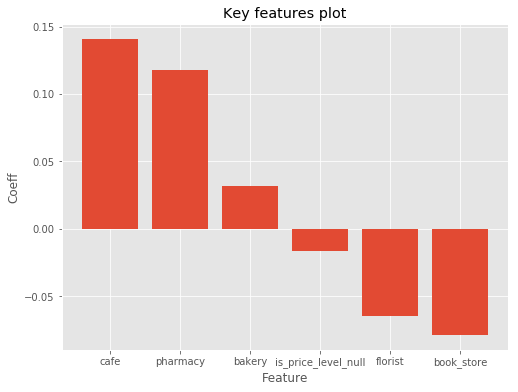

In [155]:
plt.figure(figsize=(8,6))
plt.bar(range(len(y)), y, align='center')
plt.xticks(range(len(x)), x)
plt.xlabel('Feature')
plt.ylabel('Coeff')
plt.title("Key features plot")
plt.show()